In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import os
import copy
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold, cross_validate
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib

from time import perf_counter

from utilities import drawSketch, computeLearningCurve, plotScoreCurve, plotTimeCurve, plotIterationCurve, plotConfusionMatrix, getDrawData, drawIncorrectSketches, heatmap, get_pca_components_for_var, plot_pca_components, df_to_heatmap, get_reconstruction_error, get_max_along_df_axis


# Define settings

In [7]:
# Import shared settings
from settings import random_state, n_jobs, test_size, pRows, pCols, pColNames, pScale, nSamples, names, accuracyMin, accuracyMax, max_iter
# Override settings
#...

In [8]:
# Used for plot names
dim_red_name = "pca"
casename = f"quickdraw_{dim_red_name}"


# Load and curate data

In [9]:
dataDict = getDrawData(names, nSamples=nSamples)
data = dataDict['df']
nameDict = dataDict['nameDict']

print("")
print("Loaded the following named categories, with classNumbers shown")
print(nameDict)

# Scale pixel data
for col in pColNames:
    data[col] = data[col] / pScale

Loading 2500 samples for baseball from ./data/full_numpy_bitmap_baseball.npy
Loading 2500 samples for basketball from ./data/full_numpy_bitmap_basketball.npy

Loaded the following named categories, with classNumbers shown
{'baseball': 0, 'basketball': 1}


In [10]:
# Create X, y, X_test, y_test using just the features we care about...

X_full = data.loc[:, pColNames].values
print(f'X_full.shape = {X_full.shape}')
y_full = data.loc[:, 'classNumber'].values
print(f'y_full.shape = {y_full.shape}')

X, X_test, y, y_test = train_test_split(X_full, y_full, test_size=test_size, 
                                      random_state=random_state, stratify=y_full)

print('')
print(f'X.shape = {X.shape}')
print(f'y.shape = {y.shape}')
print(f'Ratio of y=1 to y=0 for Training data: {(y == 1).sum() / float(len(y))} (should be 0.5)')


print('')
print(f'X_test.shape = {X_test.shape}')
print(f'y_test.shape = {y_test.shape}')
print(f'Ratio of y_test=1 to y_test=0 for Test data: {(y_test == 1).sum() / float(len(y_test))} (should be 0.5)')

X_full.shape = (5000, 784)
y_full.shape = (5000,)

X.shape = (4000, 784)
y.shape = (4000,)
Ratio of y=1 to y=0 for Training data: 0.5 (should be 0.5)

X_test.shape = (1000, 784)
y_test.shape = (1000,)
Ratio of y_test=1 to y_test=0 for Test data: 0.5 (should be 0.5)


# Apply initial PCA and pick key numbers of components

In [11]:
pipe_choose_components = Pipeline([('scaler', StandardScaler()), 
                                   ('pca', PCA(random_state=random_state))])

In [12]:
pipe_choose_components.fit(X)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=1,
  svd_solver='auto', tol=0.0, whiten=False))])

In [13]:
target_explained_var = (0.05, 0.10, 0.25, 0.5, 0.75, 0.85, 0.9, 0.95, 0.99, 0.9999)
# Artificially add in all components at the end
n_components_and_var = [get_pca_components_for_var(pipe_choose_components.named_steps['pca'], var) for var in target_explained_var] + [(X.shape[1], 1.0)]
if n_components_and_var[-1][0] == n_components_and_var[-2][0]:
    n_components_and_var.pop()
n_components = [x[0] for x in n_components_and_var]

In [14]:
print("n_components values to run:")

for nc, var in n_components_and_var:
    print(f'explained var = {var:.3f} --> n_components = {nc:3d} (components 0 through {nc})')

print("vector of n_components (easy copy/paste to other dimension reduction code)")
print(n_components)

n_components values to run:
explained var = 0.054 --> n_components =   1 (components 0 through 1)
explained var = 0.103 --> n_components =   2 (components 0 through 2)
explained var = 0.259 --> n_components =   9 (components 0 through 9)
explained var = 0.503 --> n_components =  34 (components 0 through 34)
explained var = 0.752 --> n_components =  98 (components 0 through 98)
explained var = 0.851 --> n_components = 156 (components 0 through 156)
explained var = 0.901 --> n_components = 206 (components 0 through 206)
explained var = 0.950 --> n_components = 295 (components 0 through 295)
explained var = 0.990 --> n_components = 478 (components 0 through 478)
explained var = 1.000 --> n_components = 666 (components 0 through 666)
explained var = 1.000 --> n_components = 784 (components 0 through 784)
vector of n_components (easy copy/paste to other dimension reduction code)
[1, 2, 9, 34, 98, 156, 206, 295, 478, 666, 784]


Calculate the reconstruction error for each set of components chosen

In [15]:
reconstruction_error = np.zeros(len(n_components))
for i, this_n in enumerate(n_components):
    pipe_reconstruction = Pipeline([('scaler', StandardScaler()), 
                                       ('pca', PCA(random_state=random_state, n_components=this_n))])
    pipe_reconstruction.fit(X)
    reconstruction_error[i] = get_reconstruction_error(X, pipe_reconstruction)

In [30]:
joblib.dump(np.array((n_components, reconstruction_error)).T, f'{casename}_reconstruction_error.pkl')

['quickdraw_pca_reconstruction_error.pkl']

Plot the explained variance as a function of number of components

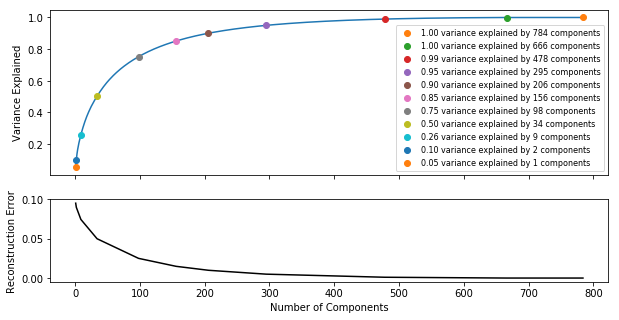

In [16]:
fig, ax = plt.subplots(nrows=2, figsize=(10, 5), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

evrc = pipe_choose_components.named_steps['pca'].explained_variance_ratio_.cumsum()
ax[0].plot(range(1, len(evrc) + 1), evrc)
to_plot = n_components_and_var.copy()
to_plot.reverse()
for i, var in to_plot:
    ax[0].plot(i, evrc[i-1], 'o', label=f'{var:.2f} variance explained by {i} components')
ax[0].legend(fontsize=8)
ax[0].set_ylabel("Variance Explained")
ax[1].plot(n_components, reconstruction_error, 'k', label='Reconstruction Error')
ax[1].set_xlabel("Number of Components")
ax[1].set_ylabel("Reconstruction Error")
fig.savefig(f'{casename}_variance_reconstruction.png')

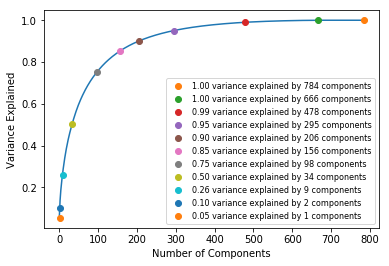

In [18]:
fig, ax = plt.subplots()
evrc = pipe_choose_components.named_steps['pca'].explained_variance_ratio_.cumsum()
ax.plot(range(0, len(evrc)), evrc)
to_plot = n_components_and_var.copy()
to_plot.reverse()
for i, var in to_plot:
    ax.plot(i, evrc[i-1], 'o', label=f'{var:.2f} variance explained by {i} components')
ax.legend(fontsize=8)
ax.set_ylabel("Variance Explained")
ax.set_xlabel("Number of Components")
fig.savefig(f'{casename}_variance.png')

In [20]:
firsts = {
    'Baseball': (y==0).argmax(),
    'Basketball': (y==1).argmax(),
}

Example Image for Baseball
Example Image for Basketball


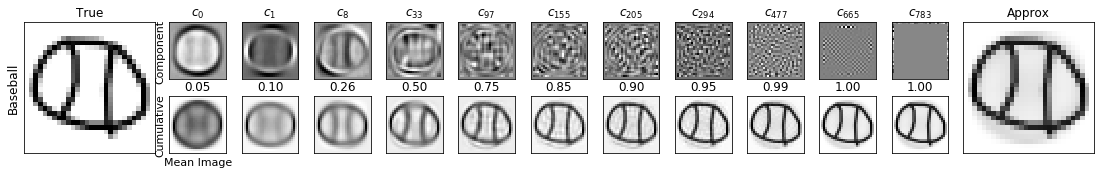

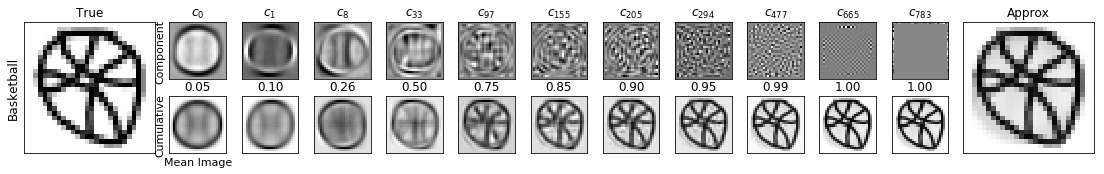

In [22]:
# Plotting scaled
X_scaled = pipe_choose_components.named_steps['scaler'].transform(X)
X_pca = pipe_choose_components.transform(X)

figures = {}

plot_steps = np.array(n_components) - 1

for name, i in firsts.items():
    print(f"Example Image for {name}")
    figures[name] = plot_pca_components(X_scaled[i], X_pca[i], scaler=pipe_choose_components.named_steps['scaler'],
                                               pca=pipe_choose_components.named_steps['pca'], 
                                               imshape=(pRows, pCols), fontsize=12, 
                                               plot_step=plot_steps, show_mean=False, far_left_label=name)
    figures[name].savefig(f'{casename}_visual_reconstruction_{name}.png')

# Run MLP using results of PCA through Grid Search

In [16]:
pipe = Pipeline([('scaler', StandardScaler()),
                  ('pca', PCA(random_state=random_state)),
                  ('mlp', MLPClassifier(max_iter=max_iter, random_state=random_state))])

#                  [0.5, 0.75, 0.9, 0.95, 0.99]
hidden_layer_sizes = [(2, ), (4, ), (6, ), (10, )]
param_grid = {'pca__n_components': n_components,
             'mlp__hidden_layer_sizes': hidden_layer_sizes,
             }
gs = GridSearchCV(pipe, param_grid=param_grid, verbose=10, cv=5, return_train_score=True, 
                  n_jobs=n_jobs)

In [17]:
gs.fit(X, y)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   44.9s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  6

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=1, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('mlp', MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       bet...=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'pca__n_components': [1, 2, 9, 34, 98, 156, 206, 295, 478, 666, 784, 784], 'mlp__hidden_layer_sizes': [(2,), (4,), (6,), (10,)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=10)

In [45]:
joblib.dump(gs, casename + "_gs.pkl")

['quickdraw_pca_gs.pkl']

In [19]:
gs.best_estimator_

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=34, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('mlp', MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       be...=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False))])

In [46]:
results = pd.DataFrame(gs.cv_results_)
results.to_csv(casename + "_results.csv")

In [23]:
results = pd.read_csv(f'{casename}_results.csv')

In [24]:
results.loc[:, ["param_mlp__hidden_layer_sizes", "param_pca__n_components", "mean_test_score", "mean_train_score"]]

,param_mlp__hidden_layer_sizes,param_pca__n_components,mean_test_score,mean_train_score
0,"(2,)",1,0.57475,0.571562
1,"(2,)",2,0.60550,0.609938
2,"(2,)",9,0.80400,0.805313
3,"(2,)",34,0.82300,0.833562
4,"(2,)",98,0.79300,0.851313
5,"(2,)",156,0.80325,0.860313
6,"(2,)",206,0.79450,0.872250
7,"(2,)",295,0.76850,0.873875
8,"(2,)",478,0.75000,0.948000
9,"(2,)",666,0.75500,0.940000


In [29]:
results

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_mlp__hidden_layer_sizes,param_pca__n_components,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0,2.483000,0.147696,0.029401,0.004453,"(2,)",1,"{'mlp__hidden_layer_sizes': (2,), 'pca__n_comp...",0.58375,0.58250,...,0.57475,0.011737,48,0.569063,0.571250,0.566562,0.582187,0.568750,0.571562,0.005516
1,1,2.269999,0.120623,0.039401,0.021086,"(2,)",2,"{'mlp__hidden_layer_sizes': (2,), 'pca__n_comp...",0.62750,0.57625,...,0.60550,0.024604,44,0.606875,0.598750,0.611875,0.623750,0.608437,0.609938,0.008140
2,2,7.691599,0.760195,0.031402,0.006828,"(2,)",9,"{'mlp__hidden_layer_sizes': (2,), 'pca__n_comp...",0.79375,0.80250,...,0.80400,0.007882,6,0.811562,0.805000,0.801250,0.805000,0.803750,0.805313,0.003412
3,3,4.816818,0.381124,0.034401,0.005315,"(2,)",34,"{'mlp__hidden_layer_sizes': (2,), 'pca__n_comp...",0.81500,0.81125,...,0.82300,0.015544,1,0.837500,0.830937,0.832812,0.836250,0.830313,0.833562,0.002855
4,4,11.409970,1.331906,0.043203,0.006461,"(2,)",98,"{'mlp__hidden_layer_sizes': (2,), 'pca__n_comp...",0.79125,0.77750,...,0.79300,0.022948,11,0.849063,0.858437,0.852187,0.850313,0.846562,0.851313,0.004004
5,5,7.506936,0.708580,0.051599,0.005461,"(2,)",156,"{'mlp__hidden_layer_sizes': (2,), 'pca__n_comp...",0.79500,0.78250,...,0.80325,0.016500,7,0.871563,0.859375,0.849688,0.859688,0.861250,0.860313,0.006951
6,6,11.249332,2.260014,0.062001,0.014071,"(2,)",206,"{'mlp__hidden_layer_sizes': (2,), 'pca__n_comp...",0.78250,0.77750,...,0.79450,0.020985,10,0.872188,0.879375,0.872500,0.862500,0.874687,0.872250,0.005511
7,7,17.996195,2.397498,0.065803,0.008972,"(2,)",295,"{'mlp__hidden_layer_sizes': (2,), 'pca__n_comp...",0.78875,0.77000,...,0.76850,0.018480,17,0.878437,0.879062,0.861875,0.872188,0.877812,0.873875,0.006482
8,8,41.479921,4.875761,0.097799,0.005493,"(2,)",478,"{'mlp__hidden_layer_sizes': (2,), 'pca__n_comp...",0.73750,0.72500,...,0.75000,0.016564,32,0.943125,0.950000,0.952187,0.949688,0.945000,0.948000,0.003381
9,9,30.964462,4.299806,0.108400,0.018575,"(2,)",666,"{'mlp__hidden_layer_sizes': (2,), 'pca__n_comp...",0.75875,0.75250,...,0.75500,0.008696,26,0.941250,0.940937,0.936562,0.938438,0.942813,0.940000,0.002219


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x205acd8f748>)

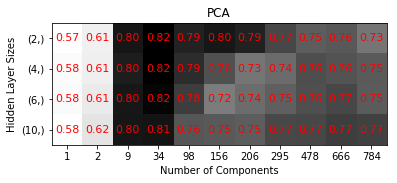

In [28]:
x_variable = "param_pca__n_components"
y_variable = "param_mlp__hidden_layer_sizes"
z_variable = "mean_test_score"

df_to_heatmap(results, x_variable, y_variable, z_variable, fontsize=11, title=f'{dim_red_name.upper()}', xlabel='Number of Components', ylabel='Hidden Layer Sizes', savefig=f'{casename}_gs.png')

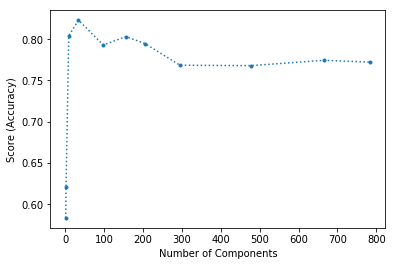

In [68]:
x_variable = "param_pca__n_components"
z_variable = "mean_test_score"
best_scores = get_max_along_df_axis(results, z_variable, x_variable)
fig, ax = plt.subplots()
ax.plot(best_scores[:, 0], best_scores[:, 1], '.:', label='MLP fit on PCA')
ax.set_xlabel("Number of Components")
ax.set_ylabel("Score (Accuracy)")
plt.show()

# Plot data using 2 components from PCA

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [80]:
pca = PCA(n_components=2)
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)

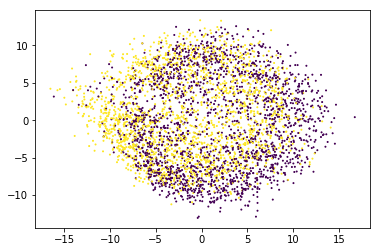

In [81]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=1, c=y,)